We will test our 2D diffusion equation against 1D diffusion equation at differing locations and compare.

We will start by defining the parameters used within our 1D and 2D code. We will set the mesh count and size, as well as diffusion, absorption, and source terms.

In [9]:
# Parameters for 1D and 2D
Lx, Ly = 10.0, 10.0  # size (cm)
Nx, Ny = 50, 50 # mesh count
D = lambda i, j: 2       # diffusion coefficient (cm)
Sigma_a = lambda i, j: 0.1 # absorption (cm^-1)
source = lambda i, j: 1e12 # source term (n/cm^3/s)

We can start with the known 1D diffusion code from class:

1D Max flux = 5.828e+12 n/cm²/s


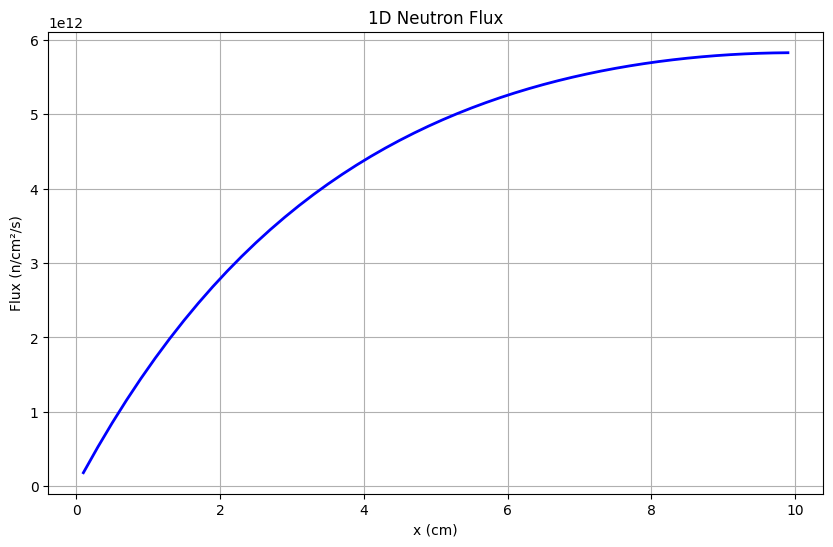

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def create_1D_grid(L, N):
    """Create a 1D grid with N cells over length L."""
    dx = L / N
    x_edges = np.linspace(0, L, N + 1)
    x_centers = x_edges[:-1] + dx / 2
    return dx, x_centers, x_edges


def build_1D_matrix_with_buckling(N, dx, D, Sigma_a, source, B_trans_sq):
    """
    Build consistent 1D matrix with:
    - Vacuum left boundary (x=0)
    - Reflecting right boundary (x=Lx)
    - Transverse buckling to account for leakage in y direction
    """
    A = np.zeros((N, N))
    b = np.zeros(N)

    for i in range(N):
        D_ctr = D(i)
        Sa_ctr = Sigma_a(i)
        # Add D*B²ₜ term to the removal rate (Sigma_a)
        effective_removal = Sa_ctr + D_ctr * B_trans_sq
        b[i] = source(i)
        A[i, i] = effective_removal

        # Left Face - VACUUM
        if i == 0:
            A[i, i] += 2 * D_ctr / dx**2
        else:
            Df = 0.5 * (D(i-1) + D_ctr)
            A[i, i] += Df / dx**2
            A[i, i - 1] = -Df / dx**2

        # Right Face - REFLECTING
        if i == N - 1:
            # Reflecting boundary - no additional terms
            pass
        else:
            Df = 0.5 * (D(i+1) + D_ctr)
            A[i, i] += Df / dx**2
            A[i, i + 1] = -Df / dx**2

    return A, b


def solve_1D_diffusion_with_buckling(L, N, D, Sigma_a, source, B_trans_sq):
    """Solve the 1D diffusion equation with transverse buckling."""
    dx, x_centers, x_edges = create_1D_grid(L, N)
    A, b = build_1D_matrix_with_buckling(N, dx, D, Sigma_a, source, B_trans_sq)
    
    # Direct solve for 1D (more efficient than SOR for smaller systems)
    phi = np.linalg.solve(A, b)
    
    return phi, x_centers, x_edges


# Calculate transverse buckling for our boundary conditions
# For vacuum at y=0 and reflecting at y=Ly, B²_y = (π/(2Ly))²
B_trans_sq = (np.pi/(2*Ly))**2

# Solve 1D problem with transverse buckling
phi_1d, x_centers, _ = solve_1D_diffusion_with_buckling(Lx, Nx, lambda i: D(i, 0), lambda i: Sigma_a(i, 0), lambda i: source(i, 0), B_trans_sq)
print(f"1D Max flux = {phi_1d.max():.3e} n/cm²/s")

plt.figure(figsize=(10, 6))
plt.plot(x_centers, phi_1d, 'b-', linewidth=2)
plt.grid(True)
plt.xlabel('x (cm)')
plt.ylabel('Flux (n/cm²/s)')
plt.title('1D Neutron Flux')
plt.show()

Here is our 2D diffusion equation

Max flux = 6.790e+12 n/cm^2/s


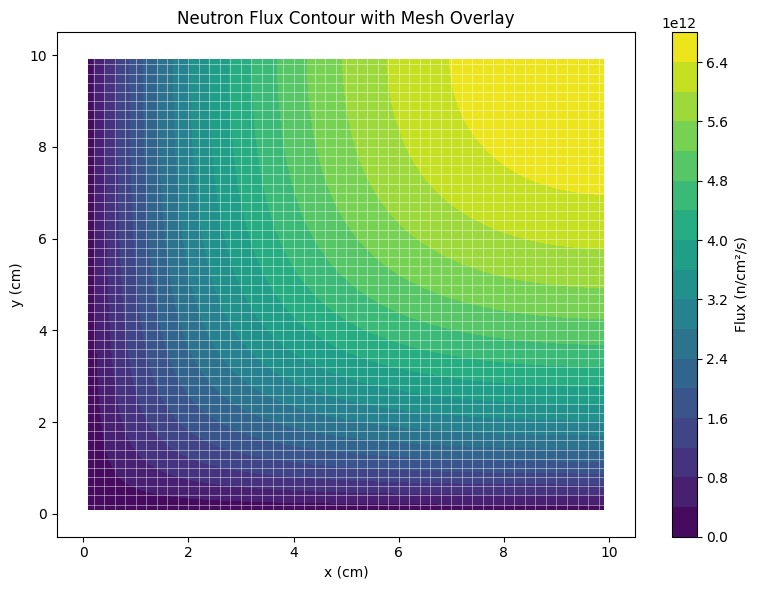

In [6]:
def create_2D_grid(Lx, Ly, Nx, Ny):
    dx = Lx / Nx
    dy = Ly / Ny
    x_edges = np.linspace(0, Lx, Nx + 1)
    y_edges = np.linspace(0, Ly, Ny + 1)
    x_centers = x_edges[:-1] + dx / 2
    y_centers = y_edges[:-1] + dy / 2
    return dx, dy, x_centers, y_centers, x_edges, y_edges

def build_2D_matrix(Nx, Ny, dx, dy, D, Sigma_a, source):
    """
    Build the diffusion matrix with:
    - Vacuum boundary at x=0 (left)
    - Reflecting boundary at x=Lx (right)
    - Vacuum boundary at y=0 (bottom)
    - Reflecting boundary at y=Ly (top)
    """
    N = Nx * Ny
    A = np.zeros((N, N))
    b = np.zeros(N)

    for j in range(Ny):
        for i in range(Nx):
            idx = i + j * Nx
            D_ctr = D(i, j)
            Sa_ctr = Sigma_a(i, j)
            b[idx] = source(i, j)
            A[idx, idx] = Sa_ctr

            # Left Face - VACUUM
            if i == 0:
                A[idx, idx] += 2 * D_ctr / dx**2
            else:
                Df = 0.5 * (D(i-1, j) + D_ctr)
                A[idx, idx] += Df / dx**2
                A[idx, idx - 1] = -Df / dx**2

            # Right Face - REFLECTING
            if i == Nx - 1:
                # Reflecting boundary - no additional terms
                pass
            else:
                Df = 0.5 * (D(i+1, j) + D_ctr)
                A[idx, idx] += Df / dx**2
                A[idx, idx + 1] = -Df / dx**2

            # Bottom Face - VACUUM
            if j == 0:
                A[idx, idx] += 2 * D_ctr / dy**2
            else:
                Df = 0.5 * (D(i, j-1) + D_ctr)
                A[idx, idx] += Df / dy**2
                A[idx, idx - Nx] = -Df / dy**2

            # Top Face - REFLECTING
            if j == Ny - 1:
                # Reflecting boundary - no additional terms
                pass
            else:
                Df = 0.5 * (D(i, j+1) + D_ctr)
                A[idx, idx] += Df / dy**2
                A[idx, idx + Nx] = -Df / dy**2

    return A, b


def sor_2D_solver(A, b, omega=1.2, tol=1e-8, max_iter=5000):
    n = b.size
    x = np.zeros(n)
    for _ in range(max_iter):
        x_old = x.copy()
        for i in range(n):
            sigma = A[i, :i] @ x[:i] + A[i, i+1:] @ x[i+1:]
            x[i] = (1 - omega) * x[i] + omega * (b[i] - sigma) / A[i, i]
        if np.linalg.norm(x - x_old) / (np.linalg.norm(x_old) + 1e-16) < tol:
            return x
    return x


def solve_2D_diffusion(Lx, Ly, Nx, Ny, D, Sigma_a, source):
    dx, dy, x_centers, y_centers, x_edges, y_edges = create_2D_grid(Lx, Ly, Nx, Ny)
    A, b = build_2D_matrix(Nx, Ny, dx, dy, D, Sigma_a, source)
    phi_flat = sor_2D_solver(A, b)
    phi = phi_flat.reshape((Ny, Nx))
    return phi, x_centers, y_centers, x_edges, y_edges

def plot_flux(phi, x_centers, y_centers, x_edges, y_edges):
    Xc, Yc = np.meshgrid(x_centers, y_centers)
    fig, ax = plt.subplots(figsize=(8, 6))
    cf = ax.contourf(Xc, Yc, phi, levels=20, cmap='viridis')
    cbar = fig.colorbar(cf, ax=ax, label='Flux (n/cm²/s)')

    # Mesh Overlay
    for xe in x_edges:
        ax.axvline(x=xe, color='white', linewidth=0.5, alpha=0.6)
    for ye in y_edges:
        ax.axhline(y=ye, color='white', linewidth=0.5, alpha=0.6)

    ax.set_xlabel('x (cm)')
    ax.set_ylabel('y (cm)')
    ax.set_title('Neutron Flux Contour with Mesh Overlay')
    plt.tight_layout()
    plt.show()

phi_2D, xc, yc, xe, ye = solve_2D_diffusion(Lx, Ly, Nx, Ny, D, Sigma_a, source)
print(f"Max flux = {phi_2D.max():.3e} n/cm^2/s")
plot_flux(phi_2D, xc, yc, xe, ye)

Now that we have our 2D diffusion code, we can compare the 1D diffusion flux at differing intervals and test the differences.

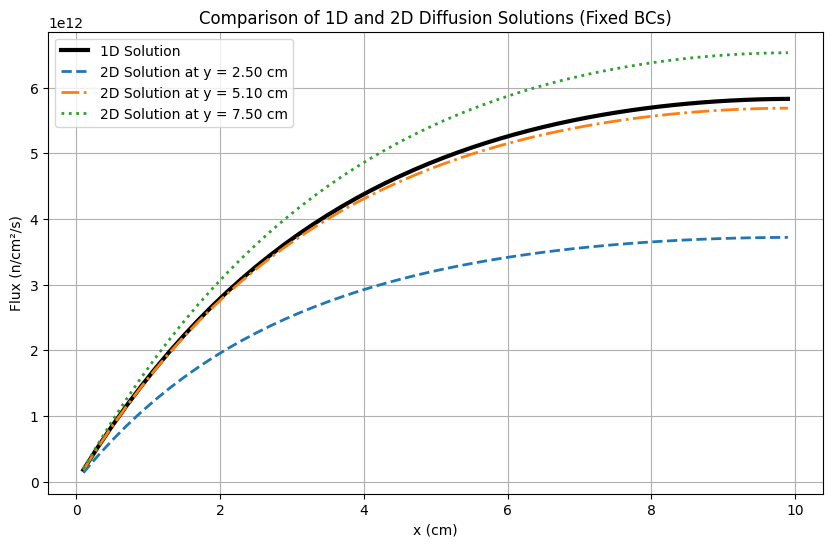

Maximum relative difference: 2.415804%
Average relative difference: 1.708310%


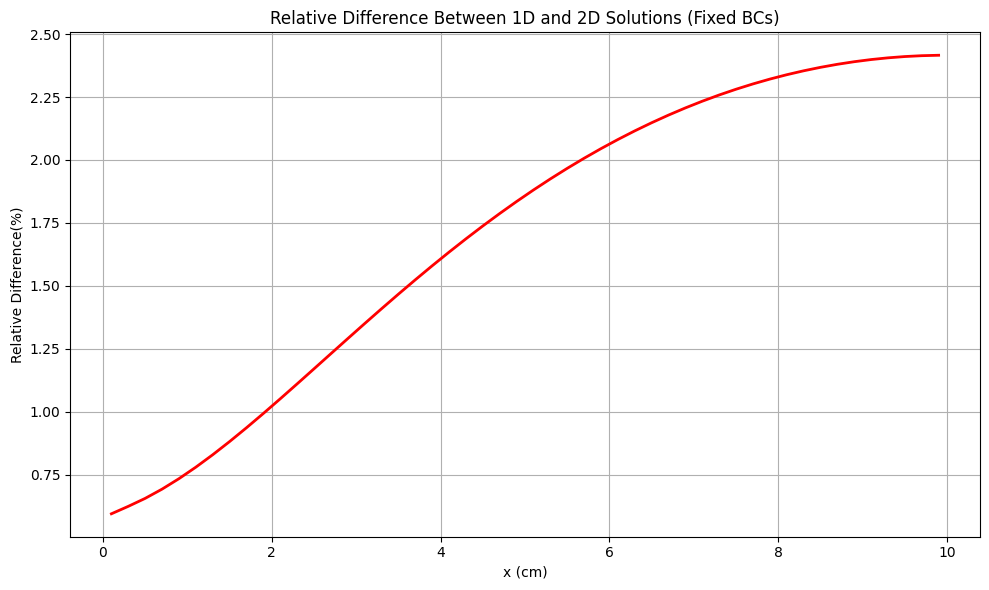

In [26]:
y_indices = [ Ny//4, Ny//2, 3*Ny//4]  # Different y-positions to check
    
# Plot the comparison
plt.figure(figsize=(10, 6))
plt.plot(x_centers, phi_1d, 'k-', linewidth=3, label='1D Solution')

linestyles = ['--', '-.', ':']
for idx, y_idx in enumerate(y_indices):
    y_pos = yc[y_idx]
    label = f'2D Solution at y = {y_pos:.2f} cm'
    plt.plot(xc, phi_2D[y_idx, :], 
            linestyles[idx % len(linestyles)], linewidth=2, label=label)

plt.grid(True)
plt.xlabel('x (cm)')
plt.ylabel('Flux (n/cm²/s)')
plt.title('Comparison of 1D and 2D Diffusion Solutions (Fixed BCs)')
plt.legend()
plt.show()

# Calculate relative difference between 1D and center of 2D
middle_y = Ny // 2
rel_diff = np.abs(phi_1d - phi_2D[middle_y, :]) / phi_1d * 100
max_rel_diff = np.max(rel_diff)
avg_rel_diff = np.mean(rel_diff)

print(f"Maximum relative difference: {max_rel_diff:.6f}%")
print(f"Average relative difference: {avg_rel_diff:.6f}%")

# Plot the relative difference
plt.figure(figsize=(10, 6))
plt.plot(x_centers, rel_diff, 'r-', linewidth=2)
plt.grid(True)
plt.xlabel('x (cm)')
plt.ylabel('Relative Difference(%)')
plt.title('Relative Difference Between 1D and 2D Solutions (Fixed BCs)')
plt.tight_layout()
plt.show()


When comparing the flux between multiple intervals of the 1D and 2D diffusion code, we get an average difference of 1.7%. Since the difference is small, we can confidently say that our 2D diffusion model accurtly models the flux from a source.